In [10]:
import logging
import config

from IPython import display
from dataset.TPL import *
import dataset.preprocessing as pre

import numpy as np
import pandas as pd
import time
import pickle
import ftn
# from pprint import pprint
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline
%reload_ext autoreload
%autoreload 2
logging.basicConfig(level=logging.INFO)

### LDA SKL MODEL- Gravity

#### 1) Import Data:

In [6]:
#Importamos la data:
gravity1=TplGravity(config=config.ds_medium)
# Some rows are small (<5 sec) or unbounded (>30m), this criteria will restrict to only the good ones
gravity1.index = gravity1.index[gravity1.index["SECONDS"] > 5]
gravity1.index = gravity1.index[gravity1.index["SECONDS"] < 1800]

#### 2) Data Preprocessing:

In [7]:
gravity1.index.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1237, 1238, 1239, 1240, 1241, 1242, 1243, 1245, 1246, 1247],
           dtype='int64', length=992)

In [8]:
%%time
#Aplicamos la función:
gravity_SES=ftn.generate_serie_SES(gravity1)

CPU times: user 1min 30s, sys: 4.75 s, total: 1min 35s
Wall time: 1min 43s


In [5]:
#result=open("gravity_SES","wb")
#pickle.dump(gravity_SES,result)
#result.close()

In [ ]:
#---------------------------------------#
#First load ()
# gravity_SES=pickle.load(open("gravity_SES","rb"))

In [11]:
#Separamos la train_data de la test_data
gravity_train,gravity_test=ftn.traintestdata(gravity_SES,0.2)

In [13]:
#Creamos la matriz toke-frequency para nuestra data de entrenamiento:
info_train_v, v= ftn.vectorizer(gravity_train)
print('Numéro de traces: ',info_train_v.shape[0])
print('Número de tokens: ',info_train_v.shape[1])
#Show vocab v: class countvectorizer()
#v.vocabulary_
#Show vocab in alphabetical order
#v.get_feature_names()

Numéro de traces:  793
Número de tokens:  10631


**3) LDA optimal model:**

In [16]:
%%time
# Define Search Param
search_params = {'n_components': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda_opt = LatentDirichletAllocation(max_iter=10)

# Init Grid Search Class
model = GridSearchCV(lda_opt, param_grid=search_params, n_jobs=-1)

# Do the Grid Search
model.fit(info_train_v)

CPU times: user 13.4 s, sys: 1.39 s, total: 14.8 s
Wall time: 9min 59s


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=-1,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15]})

In [17]:
#Best model
bestldamodel = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", bestldamodel.perplexity(info_train_v))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 13}
Best Log Likelihood Score:  -1595135.0996172582
Model Perplexity:  79.63656125144404


In [18]:
result=open("gravity_optimodel","wb")
pickle.dump(bestldamodel,result)
result.close()

In [19]:
#---------------------------------------#
#Second load ()
bestldamodel=pickle.load(open("gravity_optimodel","rb"))

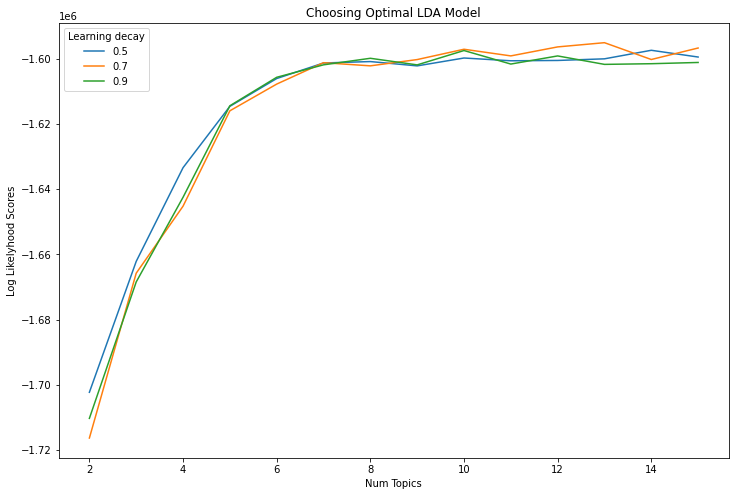

In [20]:
# Get Log Likelyhoods from Grid Search Output
log_likelyhoods_5 = []
log_likelyhoods_7 = []
log_likelyhoods_9 = []
n_topics=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]

for i in range(len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.5:
       log_likelyhoods_5.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.7:
       log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))
    elif model.cv_results_['params'][i]['learning_decay'] == 0.9:
       log_likelyhoods_9.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


In [21]:
#Verificamos que todo esté en orden:

#le entregamos nuestra matriz token-frequency creada anteriormente
bestldamodel.fit(info_train_v)

# making LDA TOP MATRIX USING CORPUS TF
lda_topic_modelling = bestldamodel.fit_transform(info_train_v)

In [22]:
#Dejamos todo como str (la info contiene números)
gravity_SES=gravity_SES.apply(str)

#Aplicamos el CV
gravity_SES_v = v.transform(gravity_SES)

In [23]:
#Mostramos la contribución de los tópicos a cada una de las traces:
df_topic_dc=ftn.topic_document(bestldamodel,gravity_SES_v)
df_topic_dc

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.000043,0.672998,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.326531,0.000043,0.000043,0.000043
1,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.999345
2,0.000067,0.721538,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.277724,0.000067,0.000067,0.000067
3,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.999260
4,0.000068,0.768704,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.230544,0.000068,0.000068,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.000032,0.274706,0.000032,0.000032,0.000032,0.724942,0.000032
988,0.475537,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.524366,0.000009
989,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.000078,0.301431,0.000078,0.000078,0.000078,0.697708,0.000078
990,0.000088,0.000088,0.000088,0.000088,0.000088,0.000088,0.000088,0.305172,0.000088,0.000088,0.000088,0.693857,0.000088


### 4) Results:

In [24]:
final_df=ftn.final_result(gravity1.index,bestldamodel,gravity_SES_v)
final_df

,Num trace,START,END,TIMEOUT,system,procname,TPL_ID,ERROR,Aborted,estimated (s),...,3,4,5,6,7,8,9,10,11,12
0,0,2020-12-01 00:16:04.547000+00:00,2020-12-01 00:19:11.750000+00:00,False,GRAVITY,bob_4415,GRAVITY_dual_obs_exp,False,False,227,...,0.000043,0.000043,0.000043,0.000043,0.000043,0.000043,0.326531,0.000043,0.000043,0.000043
1,1,2020-12-01 00:19:11.804000+00:00,2020-12-01 00:23:49.341000+00:00,False,GRAVITY,bob_4415,GRAVITY_dual_obs_swap,False,False,500,...,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.000055,0.999345
2,2,2020-12-01 00:23:49.411000+00:00,2020-12-01 00:25:34.908000+00:00,False,GRAVITY,bob_4415,GRAVITY_dual_obs_exp,False,False,138,...,0.000067,0.000067,0.000067,0.000067,0.000067,0.000067,0.277724,0.000067,0.000067,0.000067
3,3,2020-12-01 00:25:34.967000+00:00,2020-12-01 00:29:33.402000+00:00,False,GRAVITY,bob_4415,GRAVITY_dual_obs_swap,False,False,500,...,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.000062,0.999260
4,4,2020-12-01 00:29:33.453000+00:00,2020-12-01 00:31:18.444000+00:00,False,GRAVITY,bob_4415,GRAVITY_dual_obs_exp,False,False,138,...,0.000068,0.000068,0.000068,0.000068,0.000068,0.000068,0.230544,0.000068,0.000068,0.000068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987,1242,2021-01-01 19:55:07.919000+00:00,2021-01-01 19:59:19.367000+00:00,False,GRAVITY,bob_28479,GRAVITY_gen_tec_AcqFibA,False,False,400,...,0.000032,0.000032,0.000032,0.000032,0.274706,0.000032,0.000032,0.000032,0.724942,0.000032
988,1243,2021-01-01 19:59:19.458000+00:00,2021-01-01 20:10:17.247000+00:00,False,GRAVITY,bob_28479,GRAVITY_gen_tec_AcqFibB,False,False,1125,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.524366,0.000009
989,1245,2021-01-01 20:10:20.661000+00:00,2021-01-01 20:11:58.709000+00:00,False,GRAVITY,bob_28479,GRAVITY_gen_tec_PTref,False,False,135,...,0.000078,0.000078,0.000078,0.000078,0.301431,0.000078,0.000078,0.000078,0.697708,0.000078
990,1246,2021-01-01 20:11:58.798000+00:00,2021-01-01 20:13:26.902000+00:00,False,GRAVITY,bob_28479,GRAVITY_gen_tec_WFSref,False,False,123,...,0.000088,0.000088,0.000088,0.000088,0.305172,0.000088,0.000088,0.000088,0.693857,0.000088


In [25]:
#--------------------------------------#
#result=open("gravity_result","wb")
#pickle.dump(final_df,result)
#result.close()

In [26]:
#---------------------------------------#
final_result=pickle.load(open("gravity_result","rb"))

In [29]:
topic_words=ftn.show_topics(vect_class=v,lda_model=bestldamodel, n_words=30)
topic_words

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12
Word 0,"'SETUP_command_done.',",'WARNING:_new_header_block_is_added_to_the_FIT...,'WARNING:_new_header_block_is_added_to_the_FIT...,"'INS.LAMP13.STOP_Lamp_turned_off.',",'ERROR_-_RT_algorithm_unexpectedly_silent_(Mig...,"'Executing_SETUP_command_...',","'INS.LAMP13.START_Lamp_turned_on.',","'LCU:lgvttp:gvittp:data.TTPC2Y_:_{}_{}_{}_{}',",'caiERR_PARAMETER_:_invalid_parameter_unexpect...,"'INS.LAMP13.START_Lamp_turned_on.',","'Executing_SETUP_command_...',","'(errPutInStack)_Error_Stack_{}_is_FULL,_modul...","'INS.LAMP13.STOP_Lamp_turned_off.',"
Word 1,"'Executing_SETUP_command_...',","'Time_{}:_{}',","'Time_{}:_{}',","'INS.LAMP15.START_Lamp_turned_on.',","'ACTIVE_-_RT_algorithm_resumed_operation',","'SETUP_command_done.',","'INS.LAMP19.START_Lamp_turned_on.',",'LCU:lgvft1:gvips:config.Disp_offset_:_{}_{}_{...,'tacERR_DBWRITE_:_Failed_to_write_database_({}...,"'INS.LAMP19.START_Lamp_turned_on.',","'SETUP_command_done.',",'lccERR_ATTR_TYPE_:_invalid_attribute_type_(to...,"'INS.LAMP15.START_Lamp_turned_on.',"
Word 2,"'{}_(SpringGreen4)',","'{}_(SpringGreen4)',","'{}_(SpringGreen4)',","'INS.LAMP15.STOP_Lamp_turned_off.',",'Waiting_(timeout_{})_for_pending_replies_to_c...,"'{}_(SpringGreen4)',","'INS.LAMP19.STOP_Lamp_turned_off.',","'LCU:lgvttp:gvittp:data.TTPC3X_:_{}_{}_{}_{}',","""caiERR_INTERNAL_:_internal_function_call_'cai...","'INS.LAMP19.STOP_Lamp_turned_off.',","'{}_(SpringGreen4)',",'lccERR_DE_TYPE_:_invalid_data_type_(totFlagTe...,"'INS.LAMP15.STOP_Lamp_turned_off.',"
Word 3,'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,"'Executing_SETUP_command_...',","'SETUP_command_done.',","'INS.LAMP17.STOP_Lamp_turned_off.',","'Last_reply_to_command_SETGVCM_id_cmd0_received',","'Move_X,Y_{}_to_{},{}',","'INS.LAMP17.START_Lamp_turned_on.',","'FT_state.signal({})_:_{}',",'tacBgTask.c:{}_called_with_too_many_arguments...,"'INS.LAMP17.START_Lamp_turned_on.',",'Sleeping_for_{}_seconds._--_from_.Sleep_of_::...,'caiERR_WRITE_:_database_direct_write_attribut...,"'INS.LAMP17.STOP_Lamp_turned_off.',"
Word 4,'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,"'SETUP_command_done.',","'Executing_SETUP_command_...',","'INS.LAMP19.STOP_Lamp_turned_off.',",'Waiting_(timeout_{})_for_pending_replies_to_c...,'Send_command_SETMODE_to_process_gviddlServer@...,"'INS.LAMP17.STOP_Lamp_turned_off.',",'LCU:lgvft2:gviopdc:data:fluxAVG.signal_:_{}_{...,"""caiERR_INTERNAL_:_internal_function_call_'cai...","'INS.LAMP17.STOP_Lamp_turned_off.',",'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,'caiERR_WRITE_:_database_direct_write_attribut...,"'INS.LAMP17.START_Lamp_turned_on.',"
Word 5,'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,"'INS.LAMP13.STOP_Lamp_turned_off.',","'OK_(SpringGreen4)',","'INS.LAMP17.START_Lamp_turned_on.',","'Last_reply_to_command_SETGFSM_id_cmd0_received',","'Open_FDDL_Loop',","'INS.LAMP15.STOP_Lamp_turned_off.',","'LCU:lgvft2:gviopdc:config.VLTI_DL3_:_{}',","'(errPutInStack)_Error_Stack_{}_is_FULL,_modul...","'INS.LAMP15.STOP_Lamp_turned_off.',",'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,'{}_error(s)_(number={})_discarded_for_process...,"'INS.LAMP19.STOP_Lamp_turned_off.',"
Word 6,'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,"'INS.LAMP15.START_Lamp_turned_on.',","""Last_Reply_for_command_FORWARD_(buffer:'OK')"",","'INS.LAMP13.START_Lamp_turned_on.',","'Last_reply_to_command_SETLPUP_id_cmd0_received',","'Kmirror_angle:_{}',","'INS.LAMP15.START_Lamp_turned_on.',","'LCU:lgvft2:gviopdc:config.DDL_off_target_:_{}',",'tacServer.c:{}_called_with_too_many_arguments...,"'INS.LAMP15.START_Lamp_turned_on.',",'SETUP_-expoId_{}_-noExposure_-function_INS.FA...,'caiERR_WRITE_:_database_direct_write_attribut...,"'INS.LAMP19.START_Lamp_turned_on.',"
Word 7,'Sleeping_for_{}_seconds._--_from_.Sleep_of_::...,"'INS.LAMP15.STOP_Lamp_turned_off.',","'LCU:lgvttp:gvittp:data.TTPC2Y_:_{}_{}_{}_{}',","'INS.LAMP19.START_Lamp_turned_on.',",'Wa